In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import argparse

In [2]:
def getBinaryImage(img):
    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ( _ , bin_image) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
    return bin_image

In [3]:
def extractFeatures(img):
    indices = np.where(img == 0)
    x = indices[0]
    y = indices[1]
    min_arg = np.argmin(x)
    max_arg = np.argmax(x)
    co_ordinate_min = np.array([x[min_arg], y[min_arg]])  
    co_ordinate_max = np.array([x[max_arg], y[max_arg]])
    co_ordinate = (co_ordinate_min + co_ordinate_max) / 2
    return co_ordinate

In [4]:
def extractMaxPoints(img):
    indices = np.where(img == 0)
    x = indices[0]
    y = indices[1]
    max_arg = np.argmax(x)
    co_ordinate_max = np.array([x[max_arg], y[max_arg]])
    return co_ordinate_max

In [5]:
def extractMinPoints(img):
    indices = np.where(img == 0)
    x = indices[0]
    y = indices[1]
    min_arg = np.argmin(x)
    co_ordinate_min = np.array([x[min_arg], y[min_arg]])
    return co_ordinate_min

In [6]:
def plotGraph(array, name):
    print("Plotting graph")
    x = array[:,0]
    y = array[:,1]
    plt.figure()
    plt.plot(x, y, 'ro')
    #plt.show()
    plt.savefig(name)

In [7]:
def convertImg2Cartesian(points_image, image_size):
    print("converting...")
    x_i = points_image[:, 0]
    y_i = points_image[:, 1]

    x_c = y_i
    y_c = image_size[0] - x_i
    print(points_image.shape)

   # x_c = x_i - x_c
    points_cartesian = np.vstack((x_c, y_c)).T
    return points_cartesian

In [8]:
def fitCurveWithLeastSquare(points):
    x = points[:,0]
    y = points[:,1]
    o = np.ones(x.shape)
    #print("x shape = ", x.shape)

    z = np.vstack((np.square(x), x, o)).T
    #print("z shape = ", z.shape)

    t1 = np.dot(z.transpose() , z)
    #print("t1 shape = ", t1.shape)

    t2 = np.dot(np.linalg.inv(t1), z.transpose())
    #print("t2 shape = ", t2.shape)

    A = np.dot(t2, y.reshape(-1, 1))
    #print("A shape = ", A.shape)
    
    return A

    

In [9]:
def fitCurveWithTotalLeastSquare(points):

    x = points[:,0]
    y = points[:,1]
    x_sq = x ** 2

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_sq_mean = np.mean(x_sq)
    
    
    U = np.vstack(((x_sq - x_sq_mean), (x - x_mean), (y - y_mean))).T
    #print("U size = ", U.shape)

    A = np.dot(U.transpose(), U)
    #print("A size = ", A.shape)

    B = np.dot(A.transpose(), A)    

    w, v = np.linalg.eig(B)
    index = np.argmin(w)  
    coef = v[:, index]
    a, b, c = coef
    d = a * x_sq_mean + b * x_mean + c * y_mean
    coef = np.array([a, b, c, d]) 

    return coef   


In [10]:
def fitCurveWithRansac(points, outliers, accuracy, thresh):
    x = points[:,0]
    y = points[:,1]

    Np = points.shape[0]

    N_best = 0
    best_coef = np.zeros([3, 1])
    chosen_points = np.zeros([3, 2])

    e = outliers / points.shape[0]
    s = 3
    p = accuracy
    iterations = np.log(1 - p) / np.log(1 - np.power((1 - e), s))
    iterations = np.int(iterations)
    iterations = np.maximum(iterations, 20)
    print("iterations = ", iterations)

    for i in range(iterations):
    #while(True):
        #randomly select three points
        n_rows = points.shape[0]
        random_indices = np.random.choice(n_rows, size=3)
        x_random = x[random_indices]
        y_random = y[random_indices]
        points_random = np.array([x_random, y_random]).T
  
        
        #fit a model 
        coef_random = fitCurveWithTotalLeastSquare(points_random)
        if np.any(np.iscomplex(coef_random)):
            continue
        E = calculateError(points, coef_random)
     
        for i in range(len(E)):
            if float(E[i]) > thresh:
                E[i] = 0
            else:
                E[i] = 1

        N = np.sum(E)
        if N > N_best:
            N_best = N
            best_coef = coef_random
            chosen_points = points_random
        
        if N_best/Np >= accuracy:
            break
    
    return best_coef, chosen_points 


In [11]:
def calculateError(points, coef):
    x = points[:,0]
    y = points[:,1]
    x_sq = x ** 2

    a, b, c, d = coef

    E = np.square((a * x_sq) + (b * x) + (c * y) - d)
    
    return E


In [12]:
def plotLSCurve(coef, points, name):
    x = points[:, 0]
    y = points[:, 1]

    x_min = np.min(x)
    x_max = np.max(x)


    x_curve = np.linspace(x_min-100, x_max+100, 300) 
    o_curve = np.ones(x_curve.shape)
    z_curve = np.vstack((np.square(x_curve), x_curve, o_curve)).T
    #print("z_curve shape = ", z_curve.shape)
    #print("coef shape = ", coef.shape)
    y_curve = np.dot(z_curve, coef)
    #print("y_curve shape = ", y_curve.shape)

    plt.figure()
    plt.plot(x, y, 'ro', x_curve, y_curve, '-b')
    #plt.show()
    plt.savefig(name)




In [13]:
def plotTLSCurve(coef, points, name):
    a, b, c, d = coef
    x = points[:, 0]
    y = points[:, 1]
   

    x_min = np.min(x)
    x_max = np.max(x)


    x_curve = np.linspace(x_min-100, x_max+100, 300) 
    x_curve_sq = x_curve ** 2
    
    y_curve = d - (a * x_curve_sq + b * x_curve)
    y_curve /= c 

    plt.figure()
    plt.plot(x, y, 'ro', x_curve, y_curve, '-b')
    #plt.show()
    plt.savefig(name)


In [17]:
def main():

    # Parser = argparse.ArgumentParser()
    # Parser.add_argument('--BasePath', default='/home/sakshi/courses/ENPM673/project_1/', help='Base path of project1, Default:/home/sakshi/courses/ENPM673/project_1/')
    # Args = Parser.parse_args()
    # BasePath = Args.BasePath
    BasePath = '/home/sakshi/courses/ENPM673/project_1/'
    base_folder = BasePath
    video_file = BasePath + "Data/Ball_travel_2_updated.mp4"

    cap = cv2.VideoCapture(video_file)
    # img = np.array([[1,2,3],[4,5,6],[7,8,9]])
    # extractFeatures(img)
    co_ordinate_array = []
    image_size = []

    while(True):
        ret, frame = cap.read()
        if not ret:
            print("Stream ended...")
            break

        bin_image = getBinaryImage(frame)
        image_size = bin_image.shape

        co_ordinate = extractFeatures(bin_image)        
        co_ordinate_array.append(co_ordinate)         

        cv2.imshow('frame',bin_image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    co_ordinate_array = np.array(co_ordinate_array)
    print(co_ordinate_array.shape)
    co_ordinate_array = convertImg2Cartesian(co_ordinate_array, image_size)
    plotGraph(co_ordinate_array, base_folder + "graphs/video2/points.png")

    #least square method
    coef = fitCurveWithLeastSquare(co_ordinate_array)
    print(coef)
    plotLSCurve(coef, co_ordinate_array, base_folder + "graphs/video2/LScurve.png")

    #total least square method
    coef = fitCurveWithTotalLeastSquare(co_ordinate_array)
    print(coef)
    plotTLSCurve(coef, co_ordinate_array, base_folder + "graphs/video2/TLScurve.png")

    #ransac
    coef, _ = fitCurveWithRansac(co_ordinate_array, 50, 0.9, 100)
    print(coef)
    plotTLSCurve(coef, co_ordinate_array, base_folder + "graphs/video2/RANSACcurve.png")


    cap.release()
    cv2.destroyAllWindows()

Stream ended...
(28, 2)
converting...
(28, 2)
Plotting graph
[[-7.80488762e-04]
 [ 1.86170652e+00]
 [ 1.14299513e+02]]
[ 3.70140789e-04 -8.83279319e-01  4.68846998e-01  4.95242376e+01]
iterations =  20
[-3.42370332e-04  8.07070239e-01 -5.90455344e-01 -2.21257133e+02]


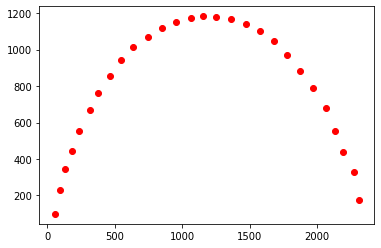

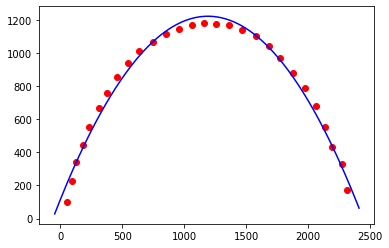

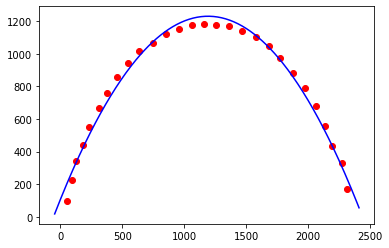

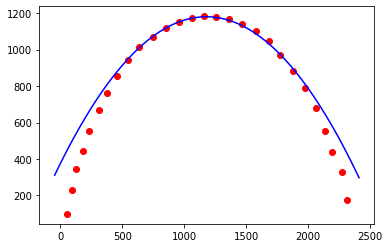

In [18]:
if __name__ == '__main__':
    main()